In [ ]:
#Yuri Muller PLumm Gomes
#PhD student at CBPF
#yurimullergomes@gmail.com

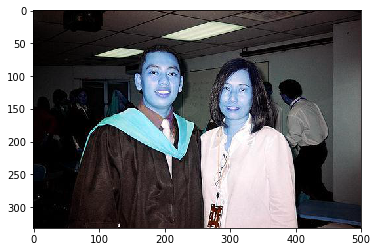

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import pandas as pd

%matplotlib inline

DATADIR = "data_folder/"
CATEGORIES = ["graduation", "picnic","meeting"]
IMG_SIZE = 50                                               #resize parameter

imgs = cv2.imread('data_folder/1007270_99118848fd.jpg') #testing the path
plt.imshow(imgs,cmap='gray')

# defining the data replacing the classes to numbers ['graduation','picnic','meeting'] -> [0,1,2]

In [2]:
data0 = pd.read_csv('dataset_images_minitest.csv',sep='\t')
category = ['graduation','picnic','meeting']
img_list = ['data_folder/' + data0['filename'][i] for i in range(data0.shape[0])]   #SAMPLEMAX = data0.shape[0]

classes = [data0['category'][i] for i in range(data0.shape[0])] 

data_class = pd.DataFrame({'category':classes})
data_class = data_class.replace(category[0],0) 
data_class = data_class.replace(category[1],1)
data_class = data_class.replace(category[2],2)

class_num  = [data_class['category'][i] for i in range(data0.shape[0])]

data_img = pd.DataFrame({'Img' : img_list})

data_final = pd.concat([data_class, data_img], axis=1)


## Here we have a list of imgs (img_list) addresses and the class of each one (class_num)

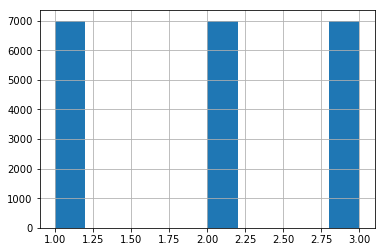

In [156]:
data_final['category'].hist()

# Augmentation:

In [8]:
import keras
#from keras import backend as K
#import from keras.preprocessing.image import ImageDataGenerator

from scipy import misc, ndimage


c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Creating the data:

In [10]:
training_data = []

def creating_training_data():
    for i in range(len(img_list)):  # do dogs and cats
        try:
            img_array = cv2.imread(img_list[i] )  # convert to array
            new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
            tipo = class_num[i]
            training_data.append([new_array,tipo])
        except Exception as e:   #I should put some warning here
                pass

creating_training_data()

In [4]:
training_data[0]

[array([[16, 15, 15, ..., 28, 25, 15],
        [16, 13, 13, ..., 26, 17, 20],
        [ 6, 12, 10, ..., 17,  4, 37],
        ...,
        [ 0,  0,  0, ..., 26, 22, 23],
        [ 1,  0,  0, ..., 67, 60, 24],
        [ 0,  0,  0, ..., 43, 15,  8]], dtype=uint8), 0]

# shuffling the data

In [213]:
import random

random.shuffle(training_data)

In [214]:
X = []
y = []

for imgs,types in training_data:
    
    y.append(types)
    X.append(imgs)

X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1)

print(np.size(X))

52467500
52467500


In [215]:
#saving the data

import pickle

pickle_out = open("X1st.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y1st.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [ ]:
#loading the saved data

#pickle_in = open("X.pickle","rb")
#X = pickle.load(pickle_in)
#pickle_in = open("y.pickle","rb")
#y = pickle.load(pickle_in)

# Data saved. Now we can construct our CNN

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential  # for a sequential model 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
#import os
#import cv2
#from tqdm import tqdm
#import pandas as pd

import pickle

pickle_in = open("X1st.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y1st.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0 #normalizing data

y = np.array(y)

c:\programdata\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X.shape[1:], len(y)

((50, 50, 1), 20987)

# data_test and data_train

In [3]:
df = 4
X_test = np.array([X[i] for i in range((len(X)//df))])
X_train = np.array([X[i] for i in range((len(X)//df),len(X))])

y_test = np.array([y[i] for i in range((len(y)//df))])
y_train = np.array([y[i] for i in range((len(y)//df),len(y))])

In [4]:
X_test.shape

(5246, 50, 50, 1)

In [6]:
#here I should save X and Y ...

# Tensorboard

In [4]:
from tensorflow.keras.callbacks import TensorBoard
import time
NAME = "first-puzzle-cnn-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir = 'logfp/{}'.format(NAME))

# The Convolutional NN model:

In [5]:
#The basic CNN structure is as follows: Convolution -> Pooling -> Convolution -> Pooling -> Fully Connected Layer -> Output

model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_test.shape[1:]))   #convolution
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))                                 # convolution
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))                                 # convolution
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))

model.add(Dense(3))
model.add(Activation('sigmoid'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

my_model = model.fit(X, y, batch_size=32, epochs=20,validation_split=0.3,callbacks=[tensorboard])


Train on 14690 samples, validate on 6297 samples
Epoch 1/20


 6496/14690 [============>.................] - ETA: 32:44 - loss: 1.0984 - acc: 0.37 - ETA: 24:28 - loss: 1.1174 - acc: 0.39 - ETA: 21:27 - loss: 1.0936 - acc: 0.41 - ETA: 20:46 - loss: 1.1276 - acc: 0.40 - ETA: 20:44 - loss: 1.1220 - acc: 0.40 - ETA: 20:08 - loss: 1.1145 - acc: 0.40 - ETA: 19:27 - loss: 1.1107 - acc: 0.41 - ETA: 19:11 - loss: 1.1166 - acc: 0.38 - ETA: 18:44 - loss: 1.1146 - acc: 0.36 - ETA: 18:52 - loss: 1.1131 - acc: 0.36 - ETA: 18:35 - loss: 1.1119 - acc: 0.36 - ETA: 18:21 - loss: 1.1108 - acc: 0.36 - ETA: 18:05 - loss: 1.1095 - acc: 0.37 - ETA: 17:51 - loss: 1.1090 - acc: 0.36 - ETA: 17:33 - loss: 1.1074 - acc: 0.36 - ETA: 17:23 - loss: 1.1088 - acc: 0.36 - ETA: 17:09 - loss: 1.1073 - acc: 0.37 - ETA: 17:04 - loss: 1.1077 - acc: 0.36 - ETA: 17:00 - loss: 1.1073 - acc: 0.36 - ETA: 16:53 - loss: 1.1069 - acc: 0.35 - ETA: 16:45 - loss: 1.1065 - acc: 0.35 - ETA: 16:40 - loss: 1.1062 - acc: 0.35 - ETA: 16:29 - loss: 1.1055 - acc: 0.35 - ETA: 16:17 - loss: 1.1054 - acc: 

 6528/14690 [============>.................] - ETA: 11:55 - loss: 0.9568 - acc: 0.56 - ETA: 11:51 - loss: 0.9366 - acc: 0.57 - ETA: 11:48 - loss: 0.9692 - acc: 0.54 - ETA: 11:48 - loss: 0.9775 - acc: 0.53 - ETA: 11:48 - loss: 0.9829 - acc: 0.51 - ETA: 11:47 - loss: 0.9890 - acc: 0.51 - ETA: 11:46 - loss: 1.0061 - acc: 0.49 - ETA: 11:44 - loss: 1.0094 - acc: 0.49 - ETA: 11:50 - loss: 1.0106 - acc: 0.49 - ETA: 11:51 - loss: 1.0052 - acc: 0.50 - ETA: 11:51 - loss: 1.0076 - acc: 0.49 - ETA: 11:54 - loss: 1.0027 - acc: 0.50 - ETA: 12:00 - loss: 0.9948 - acc: 0.52 - ETA: 12:06 - loss: 0.9888 - acc: 0.53 - ETA: 12:10 - loss: 0.9933 - acc: 0.52 - ETA: 12:11 - loss: 0.9881 - acc: 0.52 - ETA: 12:18 - loss: 0.9892 - acc: 0.52 - ETA: 12:21 - loss: 0.9928 - acc: 0.52 - ETA: 12:24 - loss: 0.9939 - acc: 0.52 - ETA: 12:28 - loss: 0.9915 - acc: 0.52 - ETA: 12:27 - loss: 0.9910 - acc: 0.52 - ETA: 12:29 - loss: 0.9919 - acc: 0.52 - ETA: 12:27 - loss: 0.9869 - acc: 0.53 - ETA: 12:22 - loss: 0.9853 - acc: 

14690/14690 [==============================] - ETA: 1:32 - loss: 0.9417 - acc: 0.555 - ETA: 1:30 - loss: 0.9416 - acc: 0.555 - ETA: 1:28 - loss: 0.9417 - acc: 0.555 - ETA: 1:26 - loss: 0.9415 - acc: 0.555 - ETA: 1:25 - loss: 0.9414 - acc: 0.555 - ETA: 1:23 - loss: 0.9415 - acc: 0.555 - ETA: 1:21 - loss: 0.9416 - acc: 0.555 - ETA: 1:19 - loss: 0.9419 - acc: 0.554 - ETA: 1:17 - loss: 0.9418 - acc: 0.554 - ETA: 1:15 - loss: 0.9416 - acc: 0.554 - ETA: 1:13 - loss: 0.9417 - acc: 0.554 - ETA: 1:12 - loss: 0.9413 - acc: 0.555 - ETA: 1:10 - loss: 0.9411 - acc: 0.555 - ETA: 1:08 - loss: 0.9411 - acc: 0.555 - ETA: 1:06 - loss: 0.9415 - acc: 0.554 - ETA: 1:04 - loss: 0.9411 - acc: 0.555 - ETA: 1:02 - loss: 0.9412 - acc: 0.555 - ETA: 1:01 - loss: 0.9407 - acc: 0.555 - ETA: 59s - loss: 0.9411 - acc: 0.555 - ETA: 57s - loss: 0.9412 - acc: 0.55 - ETA: 55s - loss: 0.9411 - acc: 0.55 - ETA: 53s - loss: 0.9407 - acc: 0.55 - ETA: 51s - loss: 0.9406 - acc: 0.55 - ETA: 50s - loss: 0.9404 - acc: 0.55 - ETA:

 6528/14690 [============>.................] - ETA: 11:55 - loss: 0.8183 - acc: 0.59 - ETA: 11:53 - loss: 0.9418 - acc: 0.57 - ETA: 11:53 - loss: 0.9765 - acc: 0.56 - ETA: 11:50 - loss: 1.0022 - acc: 0.50 - ETA: 11:50 - loss: 0.9984 - acc: 0.51 - ETA: 11:47 - loss: 0.9753 - acc: 0.54 - ETA: 11:45 - loss: 0.9677 - acc: 0.55 - ETA: 11:45 - loss: 0.9627 - acc: 0.55 - ETA: 11:44 - loss: 0.9465 - acc: 0.57 - ETA: 11:47 - loss: 0.9364 - acc: 0.57 - ETA: 11:45 - loss: 0.9411 - acc: 0.57 - ETA: 11:43 - loss: 0.9336 - acc: 0.57 - ETA: 11:41 - loss: 0.9401 - acc: 0.57 - ETA: 11:40 - loss: 0.9333 - acc: 0.56 - ETA: 11:40 - loss: 0.9282 - acc: 0.57 - ETA: 11:39 - loss: 0.9182 - acc: 0.57 - ETA: 11:37 - loss: 0.9170 - acc: 0.57 - ETA: 11:36 - loss: 0.9087 - acc: 0.58 - ETA: 11:34 - loss: 0.9006 - acc: 0.58 - ETA: 11:32 - loss: 0.9035 - acc: 0.59 - ETA: 11:30 - loss: 0.9033 - acc: 0.59 - ETA: 11:28 - loss: 0.9000 - acc: 0.59 - ETA: 11:26 - loss: 0.9005 - acc: 0.59 - ETA: 11:25 - loss: 0.8984 - acc: 

 6528/14690 [============>.................] - ETA: 12:02 - loss: 0.7155 - acc: 0.75 - ETA: 11:58 - loss: 0.7598 - acc: 0.71 - ETA: 11:56 - loss: 0.7565 - acc: 0.71 - ETA: 11:55 - loss: 0.7636 - acc: 0.67 - ETA: 11:53 - loss: 0.7858 - acc: 0.66 - ETA: 11:50 - loss: 0.7953 - acc: 0.66 - ETA: 11:47 - loss: 0.7858 - acc: 0.66 - ETA: 11:45 - loss: 0.7898 - acc: 0.66 - ETA: 11:49 - loss: 0.8086 - acc: 0.63 - ETA: 11:47 - loss: 0.8150 - acc: 0.63 - ETA: 11:44 - loss: 0.7939 - acc: 0.64 - ETA: 11:42 - loss: 0.8020 - acc: 0.65 - ETA: 11:40 - loss: 0.7988 - acc: 0.65 - ETA: 11:38 - loss: 0.8127 - acc: 0.64 - ETA: 11:36 - loss: 0.8032 - acc: 0.65 - ETA: 11:34 - loss: 0.7991 - acc: 0.65 - ETA: 11:32 - loss: 0.8090 - acc: 0.65 - ETA: 11:31 - loss: 0.8160 - acc: 0.65 - ETA: 11:29 - loss: 0.8022 - acc: 0.66 - ETA: 11:28 - loss: 0.8167 - acc: 0.65 - ETA: 11:26 - loss: 0.8223 - acc: 0.64 - ETA: 11:24 - loss: 0.8170 - acc: 0.64 - ETA: 11:22 - loss: 0.8096 - acc: 0.65 - ETA: 11:20 - loss: 0.8111 - acc: 

14690/14690 [==============================] - ETA: 1:19 - loss: 0.8263 - acc: 0.631 - ETA: 1:17 - loss: 0.8259 - acc: 0.632 - ETA: 1:16 - loss: 0.8266 - acc: 0.631 - ETA: 1:14 - loss: 0.8264 - acc: 0.632 - ETA: 1:12 - loss: 0.8259 - acc: 0.632 - ETA: 1:11 - loss: 0.8266 - acc: 0.631 - ETA: 1:09 - loss: 0.8263 - acc: 0.632 - ETA: 1:08 - loss: 0.8267 - acc: 0.632 - ETA: 1:06 - loss: 0.8269 - acc: 0.631 - ETA: 1:05 - loss: 0.8270 - acc: 0.631 - ETA: 1:03 - loss: 0.8270 - acc: 0.631 - ETA: 1:01 - loss: 0.8269 - acc: 0.632 - ETA: 1:00 - loss: 0.8267 - acc: 0.632 - ETA: 58s - loss: 0.8270 - acc: 0.631 - ETA: 57s - loss: 0.8270 - acc: 0.63 - ETA: 55s - loss: 0.8270 - acc: 0.63 - ETA: 53s - loss: 0.8272 - acc: 0.63 - ETA: 52s - loss: 0.8275 - acc: 0.63 - ETA: 50s - loss: 0.8274 - acc: 0.63 - ETA: 49s - loss: 0.8277 - acc: 0.63 - ETA: 47s - loss: 0.8277 - acc: 0.63 - ETA: 46s - loss: 0.8280 - acc: 0.63 - ETA: 44s - loss: 0.8274 - acc: 0.63 - ETA: 42s - loss: 0.8273 - acc: 0.63 - ETA: 41s - los

 6528/14690 [============>.................] - ETA: 12:15 - loss: 0.7669 - acc: 0.62 - ETA: 12:00 - loss: 0.7832 - acc: 0.62 - ETA: 11:52 - loss: 0.7296 - acc: 0.66 - ETA: 11:47 - loss: 0.8278 - acc: 0.60 - ETA: 11:44 - loss: 0.7964 - acc: 0.62 - ETA: 11:40 - loss: 0.7633 - acc: 0.64 - ETA: 11:37 - loss: 0.7491 - acc: 0.65 - ETA: 11:34 - loss: 0.7425 - acc: 0.66 - ETA: 11:37 - loss: 0.7551 - acc: 0.65 - ETA: 11:36 - loss: 0.7489 - acc: 0.66 - ETA: 11:36 - loss: 0.7705 - acc: 0.65 - ETA: 11:34 - loss: 0.7776 - acc: 0.64 - ETA: 11:33 - loss: 0.7796 - acc: 0.63 - ETA: 11:31 - loss: 0.7823 - acc: 0.63 - ETA: 11:30 - loss: 0.7944 - acc: 0.62 - ETA: 11:27 - loss: 0.7833 - acc: 0.63 - ETA: 11:25 - loss: 0.7854 - acc: 0.63 - ETA: 11:25 - loss: 0.7889 - acc: 0.63 - ETA: 11:23 - loss: 0.7993 - acc: 0.63 - ETA: 11:21 - loss: 0.8003 - acc: 0.63 - ETA: 11:19 - loss: 0.7994 - acc: 0.63 - ETA: 11:17 - loss: 0.7989 - acc: 0.63 - ETA: 11:16 - loss: 0.7951 - acc: 0.63 - ETA: 11:14 - loss: 0.7949 - acc: 

 6528/14690 [============>.................] - ETA: 11:50 - loss: 0.9051 - acc: 0.59 - ETA: 12:08 - loss: 0.8089 - acc: 0.65 - ETA: 11:59 - loss: 0.7691 - acc: 0.68 - ETA: 11:52 - loss: 0.7655 - acc: 0.69 - ETA: 11:48 - loss: 0.7625 - acc: 0.67 - ETA: 11:47 - loss: 0.7624 - acc: 0.67 - ETA: 11:45 - loss: 0.7659 - acc: 0.66 - ETA: 11:42 - loss: 0.7821 - acc: 0.65 - ETA: 11:40 - loss: 0.7730 - acc: 0.65 - ETA: 11:38 - loss: 0.7633 - acc: 0.65 - ETA: 11:35 - loss: 0.7502 - acc: 0.67 - ETA: 11:33 - loss: 0.7546 - acc: 0.67 - ETA: 11:31 - loss: 0.7582 - acc: 0.67 - ETA: 11:29 - loss: 0.7486 - acc: 0.68 - ETA: 11:27 - loss: 0.7405 - acc: 0.68 - ETA: 11:24 - loss: 0.7411 - acc: 0.68 - ETA: 11:22 - loss: 0.7346 - acc: 0.68 - ETA: 11:20 - loss: 0.7267 - acc: 0.69 - ETA: 11:18 - loss: 0.7187 - acc: 0.69 - ETA: 11:16 - loss: 0.7142 - acc: 0.70 - ETA: 11:19 - loss: 0.7144 - acc: 0.69 - ETA: 11:17 - loss: 0.7084 - acc: 0.69 - ETA: 11:15 - loss: 0.7012 - acc: 0.70 - ETA: 11:13 - loss: 0.6939 - acc: 

14690/14690 [==============================] - ETA: 1:20 - loss: 0.7078 - acc: 0.694 - ETA: 1:18 - loss: 0.7076 - acc: 0.694 - ETA: 1:16 - loss: 0.7077 - acc: 0.694 - ETA: 1:15 - loss: 0.7078 - acc: 0.693 - ETA: 1:13 - loss: 0.7079 - acc: 0.693 - ETA: 1:12 - loss: 0.7081 - acc: 0.693 - ETA: 1:10 - loss: 0.7081 - acc: 0.693 - ETA: 1:08 - loss: 0.7081 - acc: 0.693 - ETA: 1:07 - loss: 0.7079 - acc: 0.693 - ETA: 1:05 - loss: 0.7075 - acc: 0.693 - ETA: 1:04 - loss: 0.7077 - acc: 0.693 - ETA: 1:02 - loss: 0.7076 - acc: 0.693 - ETA: 1:00 - loss: 0.7076 - acc: 0.693 - ETA: 59s - loss: 0.7079 - acc: 0.693 - ETA: 57s - loss: 0.7082 - acc: 0.69 - ETA: 56s - loss: 0.7081 - acc: 0.69 - ETA: 54s - loss: 0.7078 - acc: 0.69 - ETA: 52s - loss: 0.7074 - acc: 0.69 - ETA: 51s - loss: 0.7069 - acc: 0.69 - ETA: 49s - loss: 0.7069 - acc: 0.69 - ETA: 48s - loss: 0.7075 - acc: 0.69 - ETA: 46s - loss: 0.7073 - acc: 0.69 - ETA: 44s - loss: 0.7072 - acc: 0.69 - ETA: 43s - loss: 0.7068 - acc: 0.69 - ETA: 41s - los

 6528/14690 [============>.................] - ETA: 11:31 - loss: 0.7299 - acc: 0.68 - ETA: 11:29 - loss: 0.7313 - acc: 0.68 - ETA: 11:48 - loss: 0.7422 - acc: 0.68 - ETA: 11:44 - loss: 0.7632 - acc: 0.67 - ETA: 11:42 - loss: 0.7115 - acc: 0.70 - ETA: 11:40 - loss: 0.6759 - acc: 0.72 - ETA: 11:38 - loss: 0.6705 - acc: 0.72 - ETA: 11:35 - loss: 0.6555 - acc: 0.73 - ETA: 11:33 - loss: 0.6433 - acc: 0.73 - ETA: 11:31 - loss: 0.6321 - acc: 0.74 - ETA: 11:29 - loss: 0.6188 - acc: 0.75 - ETA: 11:27 - loss: 0.6204 - acc: 0.75 - ETA: 11:25 - loss: 0.6251 - acc: 0.75 - ETA: 11:24 - loss: 0.6417 - acc: 0.74 - ETA: 11:22 - loss: 0.6333 - acc: 0.73 - ETA: 11:20 - loss: 0.6329 - acc: 0.73 - ETA: 11:18 - loss: 0.6305 - acc: 0.73 - ETA: 11:17 - loss: 0.6234 - acc: 0.73 - ETA: 11:15 - loss: 0.6284 - acc: 0.72 - ETA: 11:13 - loss: 0.6292 - acc: 0.72 - ETA: 11:11 - loss: 0.6300 - acc: 0.72 - ETA: 11:10 - loss: 0.6300 - acc: 0.72 - ETA: 11:11 - loss: 0.6323 - acc: 0.72 - ETA: 11:10 - loss: 0.6258 - acc: 

 6528/14690 [============>.................] - ETA: 11:51 - loss: 0.5143 - acc: 0.81 - ETA: 12:01 - loss: 0.5271 - acc: 0.81 - ETA: 11:55 - loss: 0.5484 - acc: 0.77 - ETA: 11:50 - loss: 0.5363 - acc: 0.77 - ETA: 11:50 - loss: 0.5208 - acc: 0.77 - ETA: 11:48 - loss: 0.5237 - acc: 0.76 - ETA: 11:45 - loss: 0.5213 - acc: 0.77 - ETA: 11:42 - loss: 0.5431 - acc: 0.75 - ETA: 11:40 - loss: 0.5428 - acc: 0.75 - ETA: 11:38 - loss: 0.5406 - acc: 0.75 - ETA: 11:36 - loss: 0.5371 - acc: 0.76 - ETA: 11:34 - loss: 0.5348 - acc: 0.77 - ETA: 11:33 - loss: 0.5518 - acc: 0.76 - ETA: 11:31 - loss: 0.5517 - acc: 0.76 - ETA: 11:29 - loss: 0.5392 - acc: 0.77 - ETA: 11:30 - loss: 0.5345 - acc: 0.77 - ETA: 11:28 - loss: 0.5382 - acc: 0.77 - ETA: 11:27 - loss: 0.5364 - acc: 0.77 - ETA: 11:26 - loss: 0.5305 - acc: 0.77 - ETA: 11:25 - loss: 0.5304 - acc: 0.77 - ETA: 11:23 - loss: 0.5415 - acc: 0.76 - ETA: 11:21 - loss: 0.5428 - acc: 0.76 - ETA: 11:20 - loss: 0.5346 - acc: 0.77 - ETA: 11:20 - loss: 0.5367 - acc: 

14690/14690 [==============================] - ETA: 1:18 - loss: 0.5294 - acc: 0.780 - ETA: 1:17 - loss: 0.5296 - acc: 0.779 - ETA: 1:15 - loss: 0.5302 - acc: 0.779 - ETA: 1:13 - loss: 0.5305 - acc: 0.779 - ETA: 1:12 - loss: 0.5309 - acc: 0.779 - ETA: 1:10 - loss: 0.5308 - acc: 0.779 - ETA: 1:09 - loss: 0.5311 - acc: 0.778 - ETA: 1:07 - loss: 0.5314 - acc: 0.778 - ETA: 1:06 - loss: 0.5311 - acc: 0.778 - ETA: 1:04 - loss: 0.5312 - acc: 0.778 - ETA: 1:02 - loss: 0.5311 - acc: 0.778 - ETA: 1:01 - loss: 0.5311 - acc: 0.778 - ETA: 59s - loss: 0.5313 - acc: 0.778 - ETA: 58s - loss: 0.5314 - acc: 0.77 - ETA: 56s - loss: 0.5314 - acc: 0.77 - ETA: 55s - loss: 0.5312 - acc: 0.77 - ETA: 53s - loss: 0.5313 - acc: 0.77 - ETA: 51s - loss: 0.5312 - acc: 0.77 - ETA: 50s - loss: 0.5312 - acc: 0.77 - ETA: 48s - loss: 0.5311 - acc: 0.77 - ETA: 47s - loss: 0.5311 - acc: 0.77 - ETA: 45s - loss: 0.5309 - acc: 0.77 - ETA: 44s - loss: 0.5310 - acc: 0.77 - ETA: 42s - loss: 0.5310 - acc: 0.77 - ETA: 40s - loss:

 6528/14690 [============>.................] - ETA: 11:46 - loss: 0.5455 - acc: 0.78 - ETA: 11:48 - loss: 0.4602 - acc: 0.82 - ETA: 11:47 - loss: 0.4649 - acc: 0.83 - ETA: 11:46 - loss: 0.4815 - acc: 0.82 - ETA: 11:44 - loss: 0.4331 - acc: 0.85 - ETA: 11:43 - loss: 0.4299 - acc: 0.84 - ETA: 11:42 - loss: 0.4176 - acc: 0.85 - ETA: 11:42 - loss: 0.4245 - acc: 0.84 - ETA: 11:40 - loss: 0.4155 - acc: 0.85 - ETA: 11:38 - loss: 0.4186 - acc: 0.85 - ETA: 11:36 - loss: 0.4200 - acc: 0.85 - ETA: 11:35 - loss: 0.4320 - acc: 0.84 - ETA: 11:33 - loss: 0.4374 - acc: 0.83 - ETA: 11:31 - loss: 0.4348 - acc: 0.83 - ETA: 11:30 - loss: 0.4297 - acc: 0.83 - ETA: 11:28 - loss: 0.4332 - acc: 0.83 - ETA: 11:26 - loss: 0.4276 - acc: 0.84 - ETA: 11:25 - loss: 0.4384 - acc: 0.82 - ETA: 11:24 - loss: 0.4286 - acc: 0.83 - ETA: 11:25 - loss: 0.4270 - acc: 0.83 - ETA: 11:23 - loss: 0.4238 - acc: 0.83 - ETA: 11:21 - loss: 0.4251 - acc: 0.83 - ETA: 11:19 - loss: 0.4211 - acc: 0.83 - ETA: 11:18 - loss: 0.4140 - acc: 

 6528/14690 [============>.................] - ETA: 13:53 - loss: 0.2604 - acc: 0.90 - ETA: 14:53 - loss: 0.2679 - acc: 0.90 - ETA: 14:18 - loss: 0.3175 - acc: 0.86 - ETA: 14:03 - loss: 0.3317 - acc: 0.84 - ETA: 13:58 - loss: 0.3324 - acc: 0.85 - ETA: 13:54 - loss: 0.3430 - acc: 0.84 - ETA: 14:00 - loss: 0.3315 - acc: 0.85 - ETA: 13:50 - loss: 0.3288 - acc: 0.85 - ETA: 13:54 - loss: 0.3372 - acc: 0.85 - ETA: 14:02 - loss: 0.3336 - acc: 0.86 - ETA: 13:56 - loss: 0.3375 - acc: 0.85 - ETA: 13:55 - loss: 0.3307 - acc: 0.86 - ETA: 14:03 - loss: 0.3341 - acc: 0.86 - ETA: 14:12 - loss: 0.3366 - acc: 0.86 - ETA: 14:17 - loss: 0.3410 - acc: 0.85 - ETA: 14:10 - loss: 0.3385 - acc: 0.86 - ETA: 14:06 - loss: 0.3332 - acc: 0.86 - ETA: 13:59 - loss: 0.3389 - acc: 0.86 - ETA: 13:55 - loss: 0.3376 - acc: 0.86 - ETA: 13:58 - loss: 0.3321 - acc: 0.86 - ETA: 14:00 - loss: 0.3303 - acc: 0.86 - ETA: 14:04 - loss: 0.3241 - acc: 0.86 - ETA: 14:11 - loss: 0.3285 - acc: 0.86 - ETA: 14:09 - loss: 0.3316 - acc: 

14690/14690 [==============================] - ETA: 1:35 - loss: 0.3399 - acc: 0.865 - ETA: 1:33 - loss: 0.3405 - acc: 0.865 - ETA: 1:31 - loss: 0.3409 - acc: 0.865 - ETA: 1:29 - loss: 0.3412 - acc: 0.864 - ETA: 1:27 - loss: 0.3419 - acc: 0.864 - ETA: 1:25 - loss: 0.3422 - acc: 0.864 - ETA: 1:23 - loss: 0.3430 - acc: 0.863 - ETA: 1:22 - loss: 0.3431 - acc: 0.863 - ETA: 1:20 - loss: 0.3428 - acc: 0.863 - ETA: 1:18 - loss: 0.3427 - acc: 0.863 - ETA: 1:16 - loss: 0.3428 - acc: 0.863 - ETA: 1:14 - loss: 0.3432 - acc: 0.863 - ETA: 1:12 - loss: 0.3431 - acc: 0.863 - ETA: 1:10 - loss: 0.3431 - acc: 0.863 - ETA: 1:08 - loss: 0.3430 - acc: 0.863 - ETA: 1:06 - loss: 0.3433 - acc: 0.863 - ETA: 1:05 - loss: 0.3433 - acc: 0.863 - ETA: 1:03 - loss: 0.3440 - acc: 0.863 - ETA: 1:01 - loss: 0.3440 - acc: 0.862 - ETA: 59s - loss: 0.3438 - acc: 0.862 - ETA: 57s - loss: 0.3445 - acc: 0.86 - ETA: 55s - loss: 0.3444 - acc: 0.86 - ETA: 53s - loss: 0.3447 - acc: 0.86 - ETA: 51s - loss: 0.3453 - acc: 0.86 - ET

 6528/14690 [============>.................] - ETA: 14:24 - loss: 0.1484 - acc: 0.96 - ETA: 14:20 - loss: 0.1973 - acc: 0.92 - ETA: 14:33 - loss: 0.1815 - acc: 0.93 - ETA: 14:35 - loss: 0.1821 - acc: 0.92 - ETA: 14:31 - loss: 0.1894 - acc: 0.92 - ETA: 14:30 - loss: 0.2448 - acc: 0.90 - ETA: 14:27 - loss: 0.2509 - acc: 0.89 - ETA: 14:25 - loss: 0.2501 - acc: 0.89 - ETA: 14:23 - loss: 0.2620 - acc: 0.88 - ETA: 14:18 - loss: 0.2597 - acc: 0.88 - ETA: 14:20 - loss: 0.2932 - acc: 0.88 - ETA: 14:19 - loss: 0.2955 - acc: 0.88 - ETA: 14:15 - loss: 0.2848 - acc: 0.88 - ETA: 14:14 - loss: 0.2930 - acc: 0.88 - ETA: 14:11 - loss: 0.2893 - acc: 0.88 - ETA: 14:09 - loss: 0.2892 - acc: 0.88 - ETA: 14:07 - loss: 0.2831 - acc: 0.89 - ETA: 14:05 - loss: 0.2783 - acc: 0.89 - ETA: 14:04 - loss: 0.2794 - acc: 0.89 - ETA: 14:01 - loss: 0.2827 - acc: 0.89 - ETA: 13:58 - loss: 0.2842 - acc: 0.89 - ETA: 13:54 - loss: 0.2855 - acc: 0.89 - ETA: 13:52 - loss: 0.2826 - acc: 0.89 - ETA: 13:50 - loss: 0.2984 - acc: 

 6528/14690 [============>.................] - ETA: 17:03 - loss: 0.2762 - acc: 0.87 - ETA: 16:13 - loss: 0.3160 - acc: 0.85 - ETA: 15:23 - loss: 0.3204 - acc: 0.85 - ETA: 14:48 - loss: 0.3430 - acc: 0.85 - ETA: 14:35 - loss: 0.3764 - acc: 0.83 - ETA: 14:18 - loss: 0.3757 - acc: 0.84 - ETA: 14:25 - loss: 0.3560 - acc: 0.85 - ETA: 14:33 - loss: 0.3441 - acc: 0.85 - ETA: 14:24 - loss: 0.3458 - acc: 0.85 - ETA: 14:12 - loss: 0.3311 - acc: 0.86 - ETA: 13:59 - loss: 0.3132 - acc: 0.87 - ETA: 13:45 - loss: 0.3078 - acc: 0.87 - ETA: 13:35 - loss: 0.3218 - acc: 0.86 - ETA: 13:25 - loss: 0.3370 - acc: 0.86 - ETA: 13:22 - loss: 0.3287 - acc: 0.86 - ETA: 13:23 - loss: 0.3405 - acc: 0.86 - ETA: 13:17 - loss: 0.3302 - acc: 0.86 - ETA: 13:16 - loss: 0.3217 - acc: 0.87 - ETA: 13:11 - loss: 0.3242 - acc: 0.87 - ETA: 13:09 - loss: 0.3252 - acc: 0.87 - ETA: 13:10 - loss: 0.3282 - acc: 0.86 - ETA: 13:09 - loss: 0.3304 - acc: 0.86 - ETA: 13:08 - loss: 0.3327 - acc: 0.86 - ETA: 13:03 - loss: 0.3339 - acc: 

14690/14690 [==============================] - ETA: 1:59 - loss: 0.2485 - acc: 0.901 - ETA: 1:56 - loss: 0.2487 - acc: 0.901 - ETA: 1:54 - loss: 0.2487 - acc: 0.901 - ETA: 1:51 - loss: 0.2485 - acc: 0.901 - ETA: 1:49 - loss: 0.2483 - acc: 0.901 - ETA: 1:47 - loss: 0.2480 - acc: 0.901 - ETA: 1:44 - loss: 0.2481 - acc: 0.901 - ETA: 1:42 - loss: 0.2484 - acc: 0.901 - ETA: 1:39 - loss: 0.2490 - acc: 0.901 - ETA: 1:37 - loss: 0.2489 - acc: 0.901 - ETA: 1:35 - loss: 0.2494 - acc: 0.901 - ETA: 1:32 - loss: 0.2492 - acc: 0.901 - ETA: 1:30 - loss: 0.2490 - acc: 0.901 - ETA: 1:27 - loss: 0.2490 - acc: 0.901 - ETA: 1:25 - loss: 0.2499 - acc: 0.900 - ETA: 1:23 - loss: 0.2499 - acc: 0.900 - ETA: 1:20 - loss: 0.2498 - acc: 0.900 - ETA: 1:18 - loss: 0.2503 - acc: 0.900 - ETA: 1:15 - loss: 0.2504 - acc: 0.900 - ETA: 1:13 - loss: 0.2505 - acc: 0.900 - ETA: 1:11 - loss: 0.2506 - acc: 0.900 - ETA: 1:08 - loss: 0.2508 - acc: 0.900 - ETA: 1:06 - loss: 0.2509 - acc: 0.900 - ETA: 1:03 - loss: 0.2509 - acc: 0

 6528/14690 [============>.................] - ETA: 15:16 - loss: 0.1402 - acc: 0.93 - ETA: 15:15 - loss: 0.1763 - acc: 0.90 - ETA: 15:23 - loss: 0.1935 - acc: 0.90 - ETA: 15:16 - loss: 0.1912 - acc: 0.90 - ETA: 15:22 - loss: 0.1833 - acc: 0.91 - ETA: 15:30 - loss: 0.1839 - acc: 0.92 - ETA: 15:32 - loss: 0.1801 - acc: 0.92 - ETA: 15:25 - loss: 0.2015 - acc: 0.92 - ETA: 15:20 - loss: 0.1881 - acc: 0.93 - ETA: 15:16 - loss: 0.1932 - acc: 0.93 - ETA: 15:16 - loss: 0.1848 - acc: 0.93 - ETA: 15:12 - loss: 0.1846 - acc: 0.93 - ETA: 15:08 - loss: 0.1870 - acc: 0.93 - ETA: 15:08 - loss: 0.1907 - acc: 0.92 - ETA: 15:06 - loss: 0.1876 - acc: 0.93 - ETA: 15:06 - loss: 0.1916 - acc: 0.92 - ETA: 15:05 - loss: 0.1885 - acc: 0.93 - ETA: 15:01 - loss: 0.1858 - acc: 0.93 - ETA: 14:57 - loss: 0.1839 - acc: 0.93 - ETA: 14:53 - loss: 0.1847 - acc: 0.93 - ETA: 14:53 - loss: 0.1803 - acc: 0.93 - ETA: 14:50 - loss: 0.1782 - acc: 0.93 - ETA: 14:46 - loss: 0.1796 - acc: 0.93 - ETA: 14:44 - loss: 0.1824 - acc: 

 6528/14690 [============>.................] - ETA: 15:03 - loss: 0.0631 - acc: 1.00 - ETA: 14:58 - loss: 0.1728 - acc: 0.93 - ETA: 14:52 - loss: 0.1687 - acc: 0.93 - ETA: 14:47 - loss: 0.1679 - acc: 0.92 - ETA: 14:59 - loss: 0.1798 - acc: 0.91 - ETA: 14:56 - loss: 0.1698 - acc: 0.92 - ETA: 14:51 - loss: 0.1893 - acc: 0.90 - ETA: 14:49 - loss: 0.1782 - acc: 0.91 - ETA: 14:47 - loss: 0.1808 - acc: 0.90 - ETA: 14:43 - loss: 0.1750 - acc: 0.91 - ETA: 14:40 - loss: 0.1834 - acc: 0.90 - ETA: 14:36 - loss: 0.1750 - acc: 0.91 - ETA: 14:37 - loss: 0.1737 - acc: 0.91 - ETA: 14:33 - loss: 0.1651 - acc: 0.92 - ETA: 14:29 - loss: 0.1634 - acc: 0.92 - ETA: 14:23 - loss: 0.1592 - acc: 0.92 - ETA: 14:19 - loss: 0.1532 - acc: 0.93 - ETA: 14:15 - loss: 0.1578 - acc: 0.92 - ETA: 14:12 - loss: 0.1578 - acc: 0.92 - ETA: 14:08 - loss: 0.1610 - acc: 0.92 - ETA: 14:06 - loss: 0.1608 - acc: 0.92 - ETA: 14:03 - loss: 0.1569 - acc: 0.93 - ETA: 14:03 - loss: 0.1557 - acc: 0.93 - ETA: 14:02 - loss: 0.1546 - acc: 

14690/14690 [==============================] - ETA: 1:38 - loss: 0.1739 - acc: 0.933 - ETA: 1:36 - loss: 0.1737 - acc: 0.933 - ETA: 1:34 - loss: 0.1735 - acc: 0.933 - ETA: 1:32 - loss: 0.1733 - acc: 0.933 - ETA: 1:30 - loss: 0.1734 - acc: 0.933 - ETA: 1:28 - loss: 0.1735 - acc: 0.933 - ETA: 1:26 - loss: 0.1735 - acc: 0.933 - ETA: 1:24 - loss: 0.1738 - acc: 0.932 - ETA: 1:22 - loss: 0.1741 - acc: 0.932 - ETA: 1:20 - loss: 0.1739 - acc: 0.932 - ETA: 1:18 - loss: 0.1737 - acc: 0.932 - ETA: 1:16 - loss: 0.1737 - acc: 0.932 - ETA: 1:14 - loss: 0.1738 - acc: 0.932 - ETA: 1:12 - loss: 0.1743 - acc: 0.932 - ETA: 1:10 - loss: 0.1745 - acc: 0.932 - ETA: 1:08 - loss: 0.1742 - acc: 0.932 - ETA: 1:06 - loss: 0.1747 - acc: 0.932 - ETA: 1:05 - loss: 0.1748 - acc: 0.932 - ETA: 1:03 - loss: 0.1749 - acc: 0.932 - ETA: 1:01 - loss: 0.1756 - acc: 0.932 - ETA: 59s - loss: 0.1756 - acc: 0.932 - ETA: 57s - loss: 0.1756 - acc: 0.93 - ETA: 55s - loss: 0.1757 - acc: 0.93 - ETA: 53s - loss: 0.1756 - acc: 0.93 - 

 6528/14690 [============>.................] - ETA: 14:28 - loss: 0.0878 - acc: 1.00 - ETA: 14:32 - loss: 0.1381 - acc: 0.96 - ETA: 14:39 - loss: 0.1219 - acc: 0.95 - ETA: 14:40 - loss: 0.1398 - acc: 0.95 - ETA: 14:42 - loss: 0.1328 - acc: 0.95 - ETA: 14:49 - loss: 0.1324 - acc: 0.94 - ETA: 14:56 - loss: 0.1802 - acc: 0.92 - ETA: 15:03 - loss: 0.1741 - acc: 0.92 - ETA: 15:00 - loss: 0.1684 - acc: 0.93 - ETA: 15:01 - loss: 0.1662 - acc: 0.93 - ETA: 14:59 - loss: 0.1562 - acc: 0.94 - ETA: 15:06 - loss: 0.1651 - acc: 0.94 - ETA: 15:08 - loss: 0.1567 - acc: 0.94 - ETA: 15:03 - loss: 0.1573 - acc: 0.93 - ETA: 15:02 - loss: 0.1482 - acc: 0.94 - ETA: 15:00 - loss: 0.1454 - acc: 0.94 - ETA: 14:56 - loss: 0.1433 - acc: 0.94 - ETA: 14:53 - loss: 0.1384 - acc: 0.94 - ETA: 14:49 - loss: 0.1374 - acc: 0.94 - ETA: 14:46 - loss: 0.1326 - acc: 0.94 - ETA: 14:43 - loss: 0.1372 - acc: 0.94 - ETA: 14:39 - loss: 0.1323 - acc: 0.94 - ETA: 14:36 - loss: 0.1356 - acc: 0.94 - ETA: 14:33 - loss: 0.1307 - acc: 

 6528/14690 [============>.................] - ETA: 15:28 - loss: 0.0946 - acc: 0.96 - ETA: 14:47 - loss: 0.0956 - acc: 0.95 - ETA: 14:41 - loss: 0.1405 - acc: 0.94 - ETA: 14:32 - loss: 0.1290 - acc: 0.95 - ETA: 14:25 - loss: 0.1266 - acc: 0.95 - ETA: 14:26 - loss: 0.1282 - acc: 0.95 - ETA: 14:29 - loss: 0.1244 - acc: 0.96 - ETA: 14:23 - loss: 0.1163 - acc: 0.96 - ETA: 14:17 - loss: 0.1182 - acc: 0.96 - ETA: 14:12 - loss: 0.1134 - acc: 0.96 - ETA: 14:08 - loss: 0.1174 - acc: 0.96 - ETA: 14:04 - loss: 0.1150 - acc: 0.96 - ETA: 14:00 - loss: 0.1094 - acc: 0.96 - ETA: 13:58 - loss: 0.1091 - acc: 0.96 - ETA: 13:58 - loss: 0.1137 - acc: 0.96 - ETA: 13:55 - loss: 0.1166 - acc: 0.96 - ETA: 13:53 - loss: 0.1158 - acc: 0.96 - ETA: 13:50 - loss: 0.1121 - acc: 0.96 - ETA: 13:49 - loss: 0.1186 - acc: 0.95 - ETA: 13:46 - loss: 0.1152 - acc: 0.95 - ETA: 13:43 - loss: 0.1152 - acc: 0.95 - ETA: 13:40 - loss: 0.1146 - acc: 0.95 - ETA: 13:38 - loss: 0.1153 - acc: 0.95 - ETA: 13:35 - loss: 0.1153 - acc: 

14690/14690 [==============================] - ETA: 1:31 - loss: 0.1450 - acc: 0.942 - ETA: 1:29 - loss: 0.1452 - acc: 0.942 - ETA: 1:28 - loss: 0.1454 - acc: 0.942 - ETA: 1:26 - loss: 0.1453 - acc: 0.942 - ETA: 1:24 - loss: 0.1456 - acc: 0.942 - ETA: 1:23 - loss: 0.1458 - acc: 0.942 - ETA: 1:21 - loss: 0.1458 - acc: 0.942 - ETA: 1:19 - loss: 0.1457 - acc: 0.942 - ETA: 1:17 - loss: 0.1456 - acc: 0.942 - ETA: 1:16 - loss: 0.1457 - acc: 0.942 - ETA: 1:14 - loss: 0.1467 - acc: 0.942 - ETA: 1:12 - loss: 0.1464 - acc: 0.942 - ETA: 1:10 - loss: 0.1466 - acc: 0.942 - ETA: 1:08 - loss: 0.1464 - acc: 0.942 - ETA: 1:07 - loss: 0.1463 - acc: 0.942 - ETA: 1:05 - loss: 0.1467 - acc: 0.942 - ETA: 1:03 - loss: 0.1469 - acc: 0.942 - ETA: 1:01 - loss: 0.1470 - acc: 0.941 - ETA: 1:00 - loss: 0.1469 - acc: 0.941 - ETA: 58s - loss: 0.1471 - acc: 0.941 - ETA: 56s - loss: 0.1473 - acc: 0.94 - ETA: 54s - loss: 0.1470 - acc: 0.94 - ETA: 52s - loss: 0.1470 - acc: 0.94 - ETA: 50s - loss: 0.1467 - acc: 0.94 - ET

 6528/14690 [============>.................] - ETA: 14:00 - loss: 0.1794 - acc: 0.93 - ETA: 14:03 - loss: 0.2396 - acc: 0.89 - ETA: 14:03 - loss: 0.1849 - acc: 0.91 - ETA: 14:06 - loss: 0.1930 - acc: 0.92 - ETA: 14:02 - loss: 0.1709 - acc: 0.92 - ETA: 14:00 - loss: 0.1559 - acc: 0.93 - ETA: 13:59 - loss: 0.1523 - acc: 0.93 - ETA: 14:00 - loss: 0.1532 - acc: 0.93 - ETA: 13:57 - loss: 0.1433 - acc: 0.94 - ETA: 13:55 - loss: 0.1380 - acc: 0.94 - ETA: 13:52 - loss: 0.1500 - acc: 0.94 - ETA: 13:49 - loss: 0.1444 - acc: 0.94 - ETA: 13:47 - loss: 0.1470 - acc: 0.93 - ETA: 13:45 - loss: 0.1388 - acc: 0.94 - ETA: 13:43 - loss: 0.1336 - acc: 0.94 - ETA: 13:41 - loss: 0.1331 - acc: 0.94 - ETA: 13:44 - loss: 0.1315 - acc: 0.94 - ETA: 13:42 - loss: 0.1325 - acc: 0.94 - ETA: 13:40 - loss: 0.1292 - acc: 0.94 - ETA: 13:39 - loss: 0.1258 - acc: 0.95 - ETA: 13:37 - loss: 0.1229 - acc: 0.95 - ETA: 13:35 - loss: 0.1245 - acc: 0.95 - ETA: 13:34 - loss: 0.1204 - acc: 0.95 - ETA: 13:32 - loss: 0.1171 - acc: 

 6528/14690 [============>.................] - ETA: 12:56 - loss: 0.2108 - acc: 0.90 - ETA: 12:36 - loss: 0.1778 - acc: 0.90 - ETA: 12:52 - loss: 0.1608 - acc: 0.91 - ETA: 12:44 - loss: 0.1286 - acc: 0.93 - ETA: 12:39 - loss: 0.1688 - acc: 0.94 - ETA: 12:41 - loss: 0.1617 - acc: 0.94 - ETA: 12:42 - loss: 0.1422 - acc: 0.95 - ETA: 12:41 - loss: 0.1378 - acc: 0.94 - ETA: 12:42 - loss: 0.1239 - acc: 0.95 - ETA: 12:37 - loss: 0.1167 - acc: 0.95 - ETA: 12:32 - loss: 0.1179 - acc: 0.95 - ETA: 12:32 - loss: 0.1142 - acc: 0.95 - ETA: 12:34 - loss: 0.1074 - acc: 0.95 - ETA: 12:32 - loss: 0.1033 - acc: 0.95 - ETA: 12:32 - loss: 0.0994 - acc: 0.96 - ETA: 12:28 - loss: 0.0967 - acc: 0.96 - ETA: 12:24 - loss: 0.1113 - acc: 0.95 - ETA: 12:21 - loss: 0.1129 - acc: 0.95 - ETA: 12:20 - loss: 0.1106 - acc: 0.95 - ETA: 12:19 - loss: 0.1168 - acc: 0.95 - ETA: 12:16 - loss: 0.1124 - acc: 0.96 - ETA: 12:16 - loss: 0.1160 - acc: 0.96 - ETA: 12:13 - loss: 0.1196 - acc: 0.96 - ETA: 12:10 - loss: 0.1170 - acc: 

14690/14690 [==============================] - ETA: 1:27 - loss: 0.1275 - acc: 0.953 - ETA: 1:25 - loss: 0.1274 - acc: 0.953 - ETA: 1:24 - loss: 0.1281 - acc: 0.952 - ETA: 1:22 - loss: 0.1279 - acc: 0.953 - ETA: 1:20 - loss: 0.1281 - acc: 0.952 - ETA: 1:18 - loss: 0.1281 - acc: 0.952 - ETA: 1:16 - loss: 0.1282 - acc: 0.952 - ETA: 1:15 - loss: 0.1282 - acc: 0.952 - ETA: 1:13 - loss: 0.1284 - acc: 0.952 - ETA: 1:11 - loss: 0.1285 - acc: 0.952 - ETA: 1:09 - loss: 0.1285 - acc: 0.952 - ETA: 1:08 - loss: 0.1284 - acc: 0.952 - ETA: 1:06 - loss: 0.1283 - acc: 0.952 - ETA: 1:04 - loss: 0.1287 - acc: 0.952 - ETA: 1:03 - loss: 0.1289 - acc: 0.952 - ETA: 1:01 - loss: 0.1288 - acc: 0.951 - ETA: 59s - loss: 0.1289 - acc: 0.951 - ETA: 57s - loss: 0.1288 - acc: 0.95 - ETA: 56s - loss: 0.1289 - acc: 0.95 - ETA: 54s - loss: 0.1288 - acc: 0.95 - ETA: 52s - loss: 0.1287 - acc: 0.95 - ETA: 50s - loss: 0.1287 - acc: 0.95 - ETA: 49s - loss: 0.1288 - acc: 0.95 - ETA: 47s - loss: 0.1288 - acc: 0.95 - ETA: 45s

 6528/14690 [============>.................] - ETA: 16:31 - loss: 0.0836 - acc: 0.96 - ETA: 15:54 - loss: 0.0795 - acc: 0.98 - ETA: 16:10 - loss: 0.0705 - acc: 0.97 - ETA: 17:04 - loss: 0.0745 - acc: 0.97 - ETA: 16:46 - loss: 0.0802 - acc: 0.97 - ETA: 16:28 - loss: 0.0720 - acc: 0.97 - ETA: 16:02 - loss: 0.0838 - acc: 0.97 - ETA: 15:48 - loss: 0.0858 - acc: 0.97 - ETA: 15:44 - loss: 0.0788 - acc: 0.97 - ETA: 15:29 - loss: 0.0970 - acc: 0.97 - ETA: 15:19 - loss: 0.0937 - acc: 0.96 - ETA: 15:09 - loss: 0.0891 - acc: 0.97 - ETA: 15:00 - loss: 0.0891 - acc: 0.97 - ETA: 14:53 - loss: 0.0832 - acc: 0.97 - ETA: 14:49 - loss: 0.0826 - acc: 0.97 - ETA: 14:43 - loss: 0.0812 - acc: 0.97 - ETA: 14:38 - loss: 0.0810 - acc: 0.97 - ETA: 14:33 - loss: 0.0820 - acc: 0.97 - ETA: 14:27 - loss: 0.0832 - acc: 0.96 - ETA: 14:25 - loss: 0.0847 - acc: 0.96 - ETA: 14:22 - loss: 0.0819 - acc: 0.96 - ETA: 14:18 - loss: 0.0835 - acc: 0.96 - ETA: 14:15 - loss: 0.0922 - acc: 0.96 - ETA: 14:12 - loss: 0.0938 - acc: 

 6528/14690 [============>.................] - ETA: 13:06 - loss: 0.0931 - acc: 0.96 - ETA: 13:18 - loss: 0.1475 - acc: 0.95 - ETA: 14:05 - loss: 0.1054 - acc: 0.96 - ETA: 13:55 - loss: 0.0893 - acc: 0.97 - ETA: 14:09 - loss: 0.0756 - acc: 0.98 - ETA: 14:12 - loss: 0.1153 - acc: 0.96 - ETA: 14:11 - loss: 0.1193 - acc: 0.96 - ETA: 14:28 - loss: 0.1131 - acc: 0.96 - ETA: 14:30 - loss: 0.1117 - acc: 0.96 - ETA: 14:25 - loss: 0.1187 - acc: 0.96 - ETA: 14:24 - loss: 0.1119 - acc: 0.96 - ETA: 14:21 - loss: 0.1108 - acc: 0.96 - ETA: 14:17 - loss: 0.1103 - acc: 0.96 - ETA: 14:21 - loss: 0.1064 - acc: 0.96 - ETA: 14:24 - loss: 0.1047 - acc: 0.96 - ETA: 14:23 - loss: 0.1051 - acc: 0.96 - ETA: 14:25 - loss: 0.1032 - acc: 0.96 - ETA: 14:23 - loss: 0.1058 - acc: 0.96 - ETA: 14:20 - loss: 0.1047 - acc: 0.96 - ETA: 14:24 - loss: 0.1160 - acc: 0.96 - ETA: 14:30 - loss: 0.1194 - acc: 0.96 - ETA: 14:29 - loss: 0.1178 - acc: 0.96 - ETA: 14:27 - loss: 0.1227 - acc: 0.96 - ETA: 14:23 - loss: 0.1284 - acc: 

14690/14690 [==============================] - ETA: 1:39 - loss: 0.0976 - acc: 0.963 - ETA: 1:37 - loss: 0.0975 - acc: 0.963 - ETA: 1:35 - loss: 0.0978 - acc: 0.963 - ETA: 1:33 - loss: 0.0978 - acc: 0.963 - ETA: 1:31 - loss: 0.0977 - acc: 0.963 - ETA: 1:29 - loss: 0.0976 - acc: 0.963 - ETA: 1:27 - loss: 0.0982 - acc: 0.962 - ETA: 1:26 - loss: 0.0985 - acc: 0.962 - ETA: 1:24 - loss: 0.0984 - acc: 0.962 - ETA: 1:22 - loss: 0.0983 - acc: 0.962 - ETA: 1:20 - loss: 0.0982 - acc: 0.962 - ETA: 1:18 - loss: 0.0982 - acc: 0.962 - ETA: 1:16 - loss: 0.0985 - acc: 0.962 - ETA: 1:14 - loss: 0.0991 - acc: 0.962 - ETA: 1:12 - loss: 0.0993 - acc: 0.962 - ETA: 1:10 - loss: 0.0996 - acc: 0.962 - ETA: 1:08 - loss: 0.0998 - acc: 0.962 - ETA: 1:06 - loss: 0.0998 - acc: 0.962 - ETA: 1:04 - loss: 0.0999 - acc: 0.962 - ETA: 1:02 - loss: 0.1001 - acc: 0.962 - ETA: 1:00 - loss: 0.1001 - acc: 0.962 - ETA: 58s - loss: 0.1000 - acc: 0.962 - ETA: 56s - loss: 0.1003 - acc: 0.96 - ETA: 54s - loss: 0.1011 - acc: 0.96 

In [ ]:
#validation_split=0.3



#If the validation error increases(positive slope) while the training error steadily decreases(negative slope) 
#then a situation of overfitting may have occurred. 
#The best predictive and fitted model would be where the validation error has its global minimum.

In [6]:
model.save('firstpuzzle.model') #save the model


In [8]:
#evaluate loss and accuracy
score = model.evaluate(X_test,y_test)


5246/5246 [==============================] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA:

In [272]:
new_model = tf.keras.models.load_model('firstpuzzle.model') #loading the model

predictions = new_model.predict([X_test]) #testing the model 

In [313]:
print("Class:",CATEGORIES[np.argmax((predictions[7]))])
#plt.imshow(X_test[7])
X_test[7].shape

Class: graduation


(50, 50, 1)

In [11]:
print("Loss:", score[0])
print("Accuracy:", score[1])

Loss: 1.0986123455875119
Accuracy: 0.3292032025081258
